# MindLens-AI -- Notebook 02: Model Training

Training a Logistic Regression baseline with 5-fold stratified cross-validation. This notebook also includes ROC/PR curves, error analysis of confident misclassifications, and an optional DistilBERT fine-tuning section.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay

from src.features import build_tfidf
from src.model import train_baseline, save_model, get_device
from src.evaluation import evaluate_single, cross_validate_model, error_analysis

sns.set_theme(style="whitegrid", palette="muted")

device = get_device()
if torch.cuda.is_available():
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("No GPU found -- LR runs on CPU anyway, DistilBERT will be slow.")

print("Ready.")

Using device: cuda
GPU detected: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA version: 12.4
Ready.


## 1. Load Data and Build TF-IDF Features

In [2]:
df = pd.read_csv("../data/processed/primary_clean.csv")
print(f"Loaded {len(df)} samples")

all_texts = df["text"].values
all_labels = df["label"].values

vectorizer, tfidf_matrix = build_tfidf(all_texts, max_features=5000)
vocab = vectorizer.get_feature_names_out()
print(f"TF-IDF shape: {tfidf_matrix.shape}")

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    tfidf_matrix, all_labels, np.arange(len(all_labels)),
    test_size=0.2, stratify=all_labels, random_state=42,
)
test_texts = all_texts[idx_test]
print(f"Train: {X_train.shape[0]}  |  Test: {X_test.shape[0]}")

Loaded 7648 samples
TF-IDF shape: (7648, 5000)
Train: 6118  |  Test: 1530


## 2. Cross-Validation (5-Fold Stratified)

In [3]:
cv_table = cross_validate_model(
    LogisticRegression,
    tfidf_matrix, all_labels,
    n_splits=5,
    model_kwargs={"class_weight": "balanced", "max_iter": 1000, "solver": "lbfgs", "random_state": 42},
)
cv_table

  Fold 1: F1=0.9596  ROC-AUC=0.9897830293168517
  Fold 2: F1=0.9630  ROC-AUC=0.9920076026910245
  Fold 3: F1=0.9633  ROC-AUC=0.9927818875458075
  Fold 4: F1=0.9619  ROC-AUC=0.9871180070648156
  Fold 5: F1=0.9563  ROC-AUC=0.9898986441385779


,fold,accuracy,precision,recall,f1,roc_auc,pr_auc
0,1,0.961438,0.990099,0.930851,0.959561,0.989783,0.992132
1,2,0.964706,0.994334,0.933511,0.962963,0.992008,0.993846
2,3,0.964706,0.986072,0.941489,0.963265,0.992782,0.993959
3,4,0.963375,0.986034,0.93883,0.961853,0.987118,0.990147
4,5,0.958143,0.98042,0.933422,0.956344,0.989899,0.992229
5,mean+/-std,0.9625 +/- 0.0028,0.9874 +/- 0.0052,0.9356 +/- 0.0044,0.9608 +/- 0.0029,0.9903 +/- 0.0022,0.9925 +/- 0.0016


## 3. Train Final Model on Train Set

In [4]:
model = train_baseline(X_train, y_train, max_iter=1000)

results = evaluate_single(model, X_test, y_test)
print("--- Test Set Performance ---")
print(results["classification_report"])
print(f"ROC-AUC: {results.get('roc_auc', 'N/A'):.4f}")
print(f"PR-AUC:  {results.get('pr_auc', 'N/A'):.4f}")

--- Test Set Performance ---
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       778
           1       0.99      0.93      0.96       752

    accuracy                           0.96      1530
   macro avg       0.96      0.96      0.96      1530
weighted avg       0.96      0.96      0.96      1530

ROC-AUC: 0.9880
PR-AUC:  0.9908


## 4. Confusion Matrix, ROC Curve & PR Curve

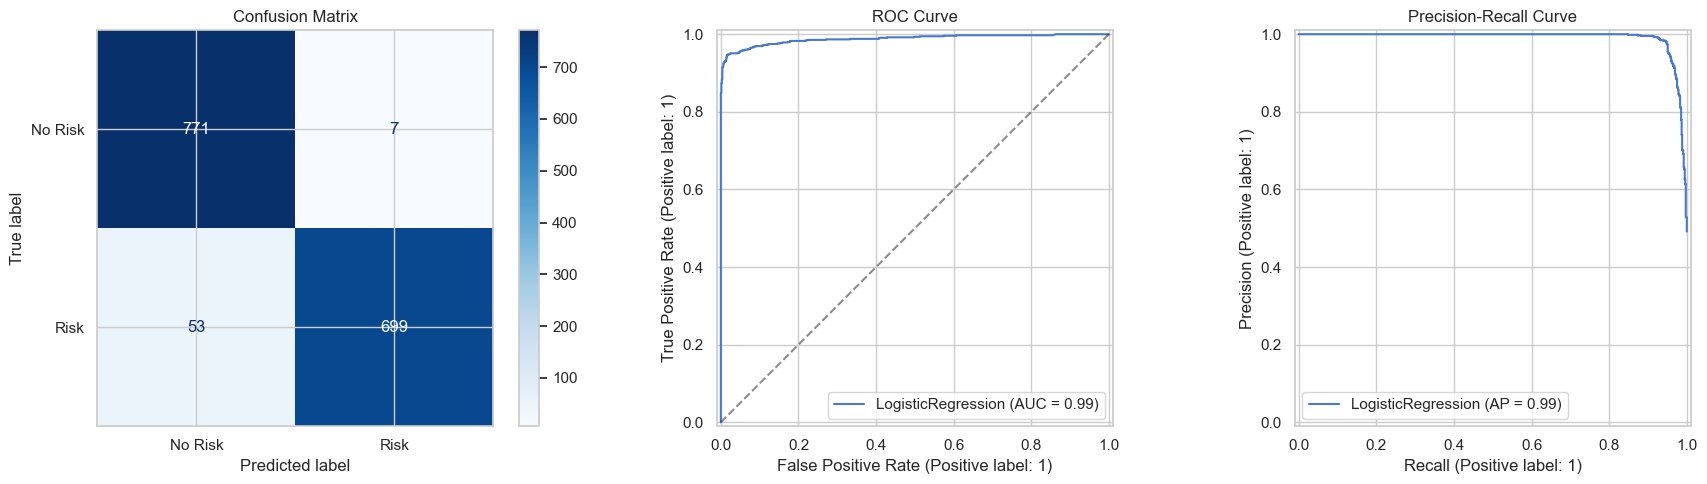

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cm = results["confusion_matrix"]
ConfusionMatrixDisplay(cm, display_labels=["No Risk", "Risk"]).plot(ax=axes[0], cmap="Blues")
axes[0].set_title("Confusion Matrix")

RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[1])
axes[1].set_title("ROC Curve")
axes[1].plot([0, 1], [0, 1], "k--", alpha=0.5)

PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axes[2])
axes[2].set_title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

## 5. Error Analysis (Top 20 FP & FN)

In [6]:
fp_df, fn_df = error_analysis(model, X_test, y_test, test_texts, n=20)

print("--- Top 20 False Positives (predicted Risk, actually No Risk) ---")
for i, row in fp_df.iterrows():
    print(f"\n  [FP-{i+1}] confidence={row['confidence']:.3f}")
    print(f"    {row['text'][:200]}...")

print("\n\n--- Top 20 False Negatives (predicted No Risk, actually Risk) ---")
for i, row in fn_df.iterrows():
    print(f"\n  [FN-{i+1}] confidence={row['confidence']:.3f}")
    print(f"    {row['text'][:200]}...")

--- Top 20 False Positives (predicted Risk, actually No Risk) ---

  [FP-1] confidence=0.694
    kevchoice i just don t get it what in a person mind could even have them on some ish like this my prayer are with her fam for real...

  [FP-2] confidence=0.638
    i know my life ha been flipped upside down when i just thought in my head that some ramen sound good...

  [FP-3] confidence=0.614
    horror wench me toooooo i feel like i ve been on the verge of an anxiety attack all day...

  [FP-4] confidence=0.542
    this week just seems to get longer and longer in term of how much i need to do and how much i m actually going to get done...

  [FP-5] confidence=0.540
    i don t want to talk to advisor they don t advise the judge your arse off...

  [FP-6] confidence=0.521
    feel like cry that s how sick i feel...

  [FP-7] confidence=0.506
    mistystilletto if it had happened to anyone else i would have peed myself laughing i scraped my leg...


--- Top 20 False Negatives (predicted No

## 6. Save Model Artifacts

In [7]:
save_model(model, vectorizer, "../data/processed/model_artifacts.joblib")

import joblib
joblib.dump({
    "X_test": X_test, "y_test": y_test, "texts_test": test_texts,
    "X_train": X_train, "y_train": y_train,
    "feature_names": list(vocab),
}, "../data/processed/test_split.joblib")
print("Artifacts saved.")

Model saved -> ../data/processed/model_artifacts.joblib
Artifacts saved.


## 7. (Optional) DistilBERT Fine-tuning

Skip this cell if you don't have a GPU with at least 4 GB VRAM.

In [8]:
from src.model import train_distilbert

train_raw = df.iloc[idx_train]["text"].values
test_raw  = df.iloc[idx_test]["text"].values

trainer, tokenizer = train_distilbert(
    train_texts=train_raw,
    train_labels=y_train,
    val_texts=test_raw,
    val_labels=y_test,
    epochs=3,
    batch_size=16,
    output_dir="../data/processed/distilbert_model",
)

print("DistilBERT evaluation:", trainer.evaluate())
print("Done.")


Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.122900,0.134412,0.964706,0.964567
2,0.069900,0.077431,0.979739,0.979292
3,0.025200,0.084470,0.980392,0.979973


DistilBERT evaluation: {'eval_loss': 0.07743105292320251, 'eval_accuracy': 0.9797385620915032, 'eval_f1': 0.9792919171676687, 'eval_runtime': 1.8836, 'eval_samples_per_second': 812.257, 'eval_steps_per_second': 25.483, 'epoch': 3.0}
Done.
